## Task A: Single classifiers

We use the "single" architecture here



In [1]:
%load_ext autoreload
%autoreload 2

from hatedetection import load_datasets
import glob
import json

train_dataset, dev_dataset, test_dataset = load_datasets(add_body=True)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:


evaluations = {
}
for model_name, path in [
    ('none', "../evaluations/beto_fine_none_weighted.json"), 
    ('title', "../evaluations/beto_fine_title.json"),   
    ('none-ft', "../evaluations/betonews_fine_none.json"),   
    ('title-ft', "../evaluations/betonews_fine_title.json"),   
    ('text-ft', "../evaluations/betonews_fine_text.json"),   
    ]:

    with open(path) as f:
        evaluations[model_name] = json.load(f)

for key, evals in evaluations.items():
    print(f"We have {len(evals['metrics'])} {key} evaluations")


We have 10 none evaluations
We have 10 title evaluations
We have 10 none-ft evaluations
We have 15 title-ft evaluations
We have 10 text-ft evaluations


In [3]:
import pandas as pd

metric_columns = [
    'calls_f1', 
    'women_f1', 'lgbti_f1', 'racism_f1',
    'class_f1', 'politics_f1', 'disabled_f1',
    'appearance_f1', 'criminal_f1', 'mean_f1',
    'mean_precision', 'mean_recall', 'hate_precision', 'hate_recall', 'hate_f1',
]


chars = [
    'women_f1', 'lgbti_f1', 'racism_f1',
    'class_f1', 'politics_f1', 'disabled_f1',
    'appearance_f1', 'criminal_f1', 
]



dfs = []
for model_name, model_results in evaluations.items():
    model_evaluations = model_results["metrics"]
    
    if not model_evaluations:
        continue
    
    df = pd.DataFrame(model_evaluations)

    df.columns = [x.split("_", 1)[1] if "_" in x else x for x in df.columns]

    without_dash = model_name.replace("_", " ")

    sub_df = df[metric_columns].copy()
    
    mean_df = pd.DataFrame({
            f"{without_dash} mean": sub_df[metric_columns].mean(), 
            f"{without_dash} std": sub_df[metric_columns].std()
        })
    dfs.append(mean_df)

result_df = pd.concat(dfs, axis=1)

#result_df["diff adding title"] = result_df["title mean"] - result_df["no-context mean"] 
#result_df["diff adding body"] = result_df["title+body mean"] - result_df["title mean"] 

result_df

,none mean,none std,title mean,title std,none-ft mean,none-ft std,title-ft mean,title-ft std,text-ft mean,text-ft std
calls_f1,0.646049,0.010023,0.637964,0.008997,0.650639,0.018557,0.690446,0.013843,0.684652,0.008791
women_f1,0.373342,0.012846,0.410703,0.009316,0.388651,0.015296,0.415650,0.017713,0.420590,0.016839
lgbti_f1,0.350842,0.018015,0.451337,0.020944,0.366127,0.019279,0.495310,0.017234,0.482327,0.019298
racism_f1,0.635225,0.014465,0.687877,0.012438,0.653023,0.009749,0.711420,0.015203,0.720456,0.003860
class_f1,0.400650,0.015907,0.491260,0.022400,0.432677,0.013410,0.512447,0.023337,0.511453,0.019697
politics_f1,0.555069,0.018201,0.579044,0.013770,0.611459,0.008188,0.628840,0.014689,0.624763,0.013419
disabled_f1,0.550690,0.016458,0.584904,0.015802,0.581650,0.013276,0.595436,0.018566,0.608863,0.017773
appearance_f1,0.725874,0.009505,0.741284,0.012012,0.741637,0.010303,0.761654,0.008339,0.766254,0.009264
criminal_f1,0.512597,0.014323,0.650342,0.011878,0.529015,0.010960,0.668950,0.012652,0.699382,0.019058
mean_f1,0.527815,0.004522,0.581635,0.005175,0.550542,0.004991,0.608906,0.007452,0.613193,0.006667


In [30]:
def print_mean(row, context, ):
    mean = row[context + " mean"]
    std = row[context + " std"]
    return f"${mean:.3f} \pm {std:.3f}$"

display_df = pd.DataFrame()

for context, model_name in [
    ("no-context", "BERT No Context"),
    ("title", "BERT Title"), 
    ("title+body", "BERT Title+Body"), 
    ]:
    display_df[model_name] = result_df.apply(lambda x: print_mean(x, context), axis=1)

display_df["+F1 adding title"] = result_df["diff adding title"].apply(lambda x: f"{'+' if x > 0 else '-'}{abs(x):.3f}")
display_df["+F1 adding body"] = result_df["diff adding body"].apply(lambda x: f"{'+' if x > 0 else '-'}{abs(x):.3f}")


display_df["metrics"] = display_df.index.map(lambda x: " ".join([y.capitalize() for y in x.split("_")]))

display_df.reset_index(inplace=True)
del display_df["index"]
display_df.set_index("metrics", inplace=True)

#display_df = display_df.T[["Mean F1"]]
display_df.sort_values("+F1 adding title", inplace=True)
display_df

,BERT No Context,BERT Title,BERT Title+Body,+F1 adding title,+F1 adding body
metrics,,,,,
Calls F1,$0.643 \pm 0.016$,$0.646 \pm 0.010$,$0.674 \pm 0.015$,+0.003,+0.029
Politics F1,$0.564 \pm 0.015$,$0.593 \pm 0.014$,$0.632 \pm 0.013$,+0.028,+0.039
Appearance F1,$0.721 \pm 0.011$,$0.750 \pm 0.010$,$0.753 \pm 0.010$,+0.029,+0.004
Disabled F1,$0.552 \pm 0.010$,$0.584 \pm 0.014$,$0.597 \pm 0.013$,+0.032,+0.013
Women F1,$0.377 \pm 0.016$,$0.418 \pm 0.014$,$0.416 \pm 0.014$,+0.041,-0.001
Racism F1,$0.637 \pm 0.006$,$0.689 \pm 0.008$,$0.694 \pm 0.010$,+0.051,+0.005
Mean F1,$0.531 \pm 0.006$,$0.586 \pm 0.004$,$0.597 \pm 0.004$,+0.055,+0.012
Lgbti F1,$0.369 \pm 0.026$,$0.450 \pm 0.029$,$0.468 \pm 0.022$,+0.081,+0.019
Class F1,$0.411 \pm 0.022$,$0.500 \pm 0.016$,$0.492 \pm 0.019$,+0.089,-0.008


In [32]:
display_df.T.columns

Index(['Calls F1', 'Politics F1', 'Appearance F1', 'Disabled F1', 'Women F1',
       'Racism F1', 'Mean F1', 'Lgbti F1', 'Class F1', 'Criminal F1'],
      dtype='object', name='metrics')

In [34]:
order = ['Calls F1', 'Politics F1', 'Appearance F1', 'Disabled F1', 'Women F1',
       'Racism F1', 'Lgbti F1', 'Class F1', 'Criminal F1', 'Mean F1']
print(display_df.T[order].to_latex(escape=False, longtable=False))

\begin{tabular}{lllllllllll}
\toprule
metrics &           Calls F1 &        Politics F1 &      Appearance F1 &        Disabled F1 &           Women F1 &          Racism F1 &           Lgbti F1 &           Class F1 &        Criminal F1 &            Mean F1 \\
\midrule
BERT No Context  &  $0.643 \pm 0.016$ &  $0.564 \pm 0.015$ &  $0.721 \pm 0.011$ &  $0.552 \pm 0.010$ &  $0.377 \pm 0.016$ &  $0.637 \pm 0.006$ &  $0.369 \pm 0.026$ &  $0.411 \pm 0.022$ &  $0.501 \pm 0.010$ &  $0.531 \pm 0.006$ \\
BERT Title       &  $0.646 \pm 0.010$ &  $0.593 \pm 0.014$ &  $0.750 \pm 0.010$ &  $0.584 \pm 0.014$ &  $0.418 \pm 0.014$ &  $0.689 \pm 0.008$ &  $0.450 \pm 0.029$ &  $0.500 \pm 0.016$ &  $0.642 \pm 0.018$ &  $0.586 \pm 0.004$ \\
BERT Title+Body  &  $0.674 \pm 0.015$ &  $0.632 \pm 0.013$ &  $0.753 \pm 0.010$ &  $0.597 \pm 0.013$ &  $0.416 \pm 0.014$ &  $0.694 \pm 0.010$ &  $0.468 \pm 0.022$ &  $0.492 \pm 0.019$ &  $0.650 \pm 0.009$ &  $0.597 \pm 0.004$ \\
+F1 adding title &             +0.003 &   

## Roc CURVES

['CALLS',
 'WOMEN',
 'LGBTI',
 'RACISM',
 'CLASS',
 'POLITICS',
 'DISABLED',
 'APPEARANCE',
 'CRIMINAL']

In [13]:
evaluations["no-context"][0].keys()

dict_keys(['predictions', 'labels', 'metrics', 'file'])

In [15]:
evaluations.keys()

dict_keys(['no-context', 'title', 'title+body'])

In [19]:
import torch 
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

data = []

auc_scores = {
    "None": [],
    "Title": [],
    "Title+Body": [],
}

for context, evals in [
    ("None", evaluations["no-context"]), 
    ("Title", evaluations["title"]),
    #("Hyphen", evaluations["hyphen"]),
    ("Title+Body", evaluations["title+body"])]:

    for i, evaluation in enumerate(evals): 
        all_preds = torch.Tensor(evaluation["predictions"])
        # Uso 2 porque es el índice de LGBTI
        lgbti_logits = all_preds[:, 2]
        y_score = torch.sigmoid(lgbti_logits)
        y_true = torch.Tensor(evaluation["labels"])[:, 2]
        fpr, tpr, _ = roc_curve(y_true, y_score)
        
        score = roc_auc_score(y_true, y_score)
        auc_scores[context].append(score)

        this_points = []

        x_interp = np.arange(0, 1, 5e-3)
        y_interp = np.interp(x_interp, xp=fpr, fp=tpr)
        for x, y in zip(x_interp, y_interp):
            this_points.append({
                "fpr": x,
                "tpr": y,
                "context": context,
                "i": i,  
            })

        data += this_points

auc_scores = {k: np.array(v) for k, v in auc_scores.items()}

#plt.plot(fpr, tpr, color='darkorange',  lw=2)


#fpr, tpr, _ = roc_curve(y_true, y_score)

#plt.plot(fpr, tpr, color='blue', lw=2)

df = pd.DataFrame(data)

auc_scores
#

{'None': array([0.79761599, 0.79978356, 0.81236395, 0.81144669, 0.8074002 ,
        0.80217815, 0.80706485, 0.80816451, 0.81867945, 0.80891364,
        0.80936399, 0.80623591, 0.83236547, 0.809686  , 0.80909212]),
 'Title': array([0.90912547, 0.89211012, 0.9008317 , 0.90743861, 0.87378465,
        0.90963816, 0.89341793, 0.88422369, 0.89277483, 0.90758352,
        0.85266738, 0.89772961, 0.90027026, 0.90951786, 0.90124686]),
 'Title+Body': array([0.89705731, 0.89519288, 0.90307541, 0.89702465, 0.89066936,
        0.88700951, 0.8972627 , 0.88379495, 0.87770073, 0.8885747 ,
        0.8879576 ])}

## Plot

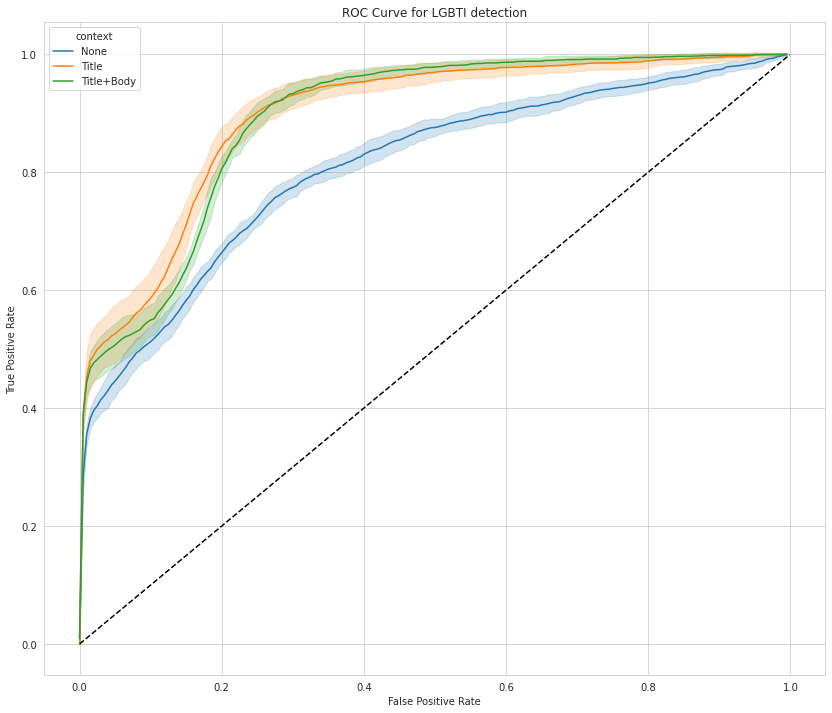

In [22]:

sns.set_style("whitegrid")
#p = df[(df["context"] == "none") & (df["i"] <= 1)]
g = sns.lineplot(data=df, x="fpr", y="tpr", hue="context", ci="sd")
# Random 
plt.plot(np.arange(0, 1, 1e-3), np.arange(0, 1, 1e-3), "k--")

plt.title("ROC Curve for LGBTI detection")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
g.figure.set_figwidth(14)
g.figure.set_figheight(12)
